In [1]:
# RFM分 以便更好地了解客戶的需求和購買行為，以圖表可視化，提供決策參考依據
# 利用Jupyter Notebook使用 Python模組 pandas、datetime、numpy數值計算 和 matplotlib 資料視覺化，對零售業的客戶資料進行 RFM 分析


In [2]:
# 導入套件
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 讀取資料
    # 中文字符，使用 encoding='utf-8' 或 encoding='unicode_escape'
    # 英文和數字字符，使用 encoding='ascii'
df = pd.read_csv("./data.csv", encoding= 'unicode_escape')

# 顯示資料前五筆
print("df.head")
df.head

df.head


<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerI

In [4]:
# 計算每個欄位缺失值比例
    # 註解：檢查資料中是否有遺失值，如果有遺失值，則需要進行處理
    # 直行橫列，舉例(1)
print("df.apply(lambda x :sum(x.isnull())/len(x), axis=0)")
df.apply(lambda x :sum(x.isnull())/len(x), axis=0)

df.apply(lambda x :sum(x.isnull())/len(x), axis=0)


InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [5]:
# 將日期欄位轉換成日期格式
df['date'] = [x.split(' ')[0] for x in df["InvoiceDate"]]
df['date'] = pd.to_datetime(df['date'])

# 將日期欄位轉換成月份格式
df['month'] = df['date'].dt.to_period('M')

# 顯示日期和月份欄位
print("df[['date', 'month']]")
df[['date', 'month']]


df[['date', 'month']]


,date,month
0,2010-12-01,2010-12
1,2010-12-01,2010-12
2,2010-12-01,2010-12
3,2010-12-01,2010-12
4,2010-12-01,2010-12
...,...,...
541904,2011-12-09,2011-12
541905,2011-12-09,2011-12
541906,2011-12-09,2011-12
541907,2011-12-09,2011-12


In [6]:
# 計算每個客戶最後一次消費日期距今的天數
R_value = df.groupby('CustomerID')['date'].max()
R_value = (df['date'].max() - R_value).dt.days

In [7]:
# 計算每個客戶的交易筆數
F_value = df.groupby('CustomerID')['InvoiceNo'].nunique()

In [8]:
# 計算每個客戶的總交易金額
df['amount'] = df['Quantity'] * df['UnitPrice']
M_value = df.groupby('CustomerID')['InvoiceNo'].sum()
M_value = df.groupby('CustomerID')['amount'].sum()

In [9]:
# 將R_value、F_value、M_value進行分箱
R_bins = [0, 30, 90, 180, 360, 720]
F_bins = [1, 2, 5, 10, 20, 5000]
M_bins = [0, 500, 2000, 5000, 10000, 200000]
R_score = pd.cut(R_value, R_bins, labels=[5,4,3,2,1], right=False)
F_score = pd.cut(F_value, F_bins, labels=[1,2,3,4,5], right=False)
M_score = pd.cut(M_value, M_bins, labels=[1,2,3,4,5], right=False)

In [10]:

# 將R_score、F_score、M_score合併成一個資料表
rfm = pd.concat([R_score, F_score, M_score], axis=1)

# 重新命名欄位
rfm.rename(columns={'date': 'R_score', 'InvoiceNo': 'F_score', 'amount': 'M_score'}, inplace=True)

In [11]:
# 將R_score、F_score、M_score轉換成數值型
rfm['R_score'] = rfm['R_score'].astype('float')
rfm['F_score'] = rfm['F_score'].astype('float')
rfm['M_score'] = rfm['M_score'].astype('float')

# 顯示資料描述
print("rfm.describe()")
rfm.describe()

# 將R_score、F_score、M_score轉換成文字型
rfm['R'] = np.where(rfm['R_score'] > 3.82, '高', '低')
rfm['F'] = np.where(rfm['F_score'] > 2.03, '高', '低')
rfm['M'] = np.where(rfm['M_score'] > 1.89, '高', '低')

rfm.describe()


In [12]:
# 將R、F、M三個欄位合併成一個欄位
rfm['RFM'] = rfm['R'] + rfm['F'] + rfm['M']

# 定義一個函數，將RFM欄位轉換成客戶類別
def rfm2grade(x):
  if x == '高高高':
    return 'VIP'
  elif x == "高低高":
    return 'High Value Customer'
  elif x == "低高高":
    return 'Medium Value Customer'
  elif x == '低低高':
    return 'Lost Customer'
  elif x == "高高低":
    return 'Medium Value Customer'
  else:
    return 'Low Value Customer'

In [13]:
# 將RFM欄位轉換成客戶類別
rfm['Customer_segment'] = rfm['RFM'].apply(rfm2grade)

# 顯示資料
rfm

,R_score,F_score,M_score,R,F,M,RFM,Customer_segment
CustomerID,,,,,,,,
12346.0,2.0,2.0,1.0,低,低,低,低低低,Low Value Customer
12347.0,5.0,3.0,3.0,高,高,高,高高高,VIP
12348.0,4.0,2.0,2.0,高,低,高,高低高,High Value Customer
12349.0,5.0,1.0,2.0,高,低,高,高低高,High Value Customer
12350.0,2.0,1.0,1.0,低,低,低,低低低,Low Value Customer
...,...,...,...,...,...,...,...,...
18280.0,2.0,1.0,1.0,低,低,低,低低低,Low Value Customer
18281.0,2.0,1.0,1.0,低,低,低,低低低,Low Value Customer
18282.0,5.0,2.0,1.0,高,低,低,高低低,Low Value Customer


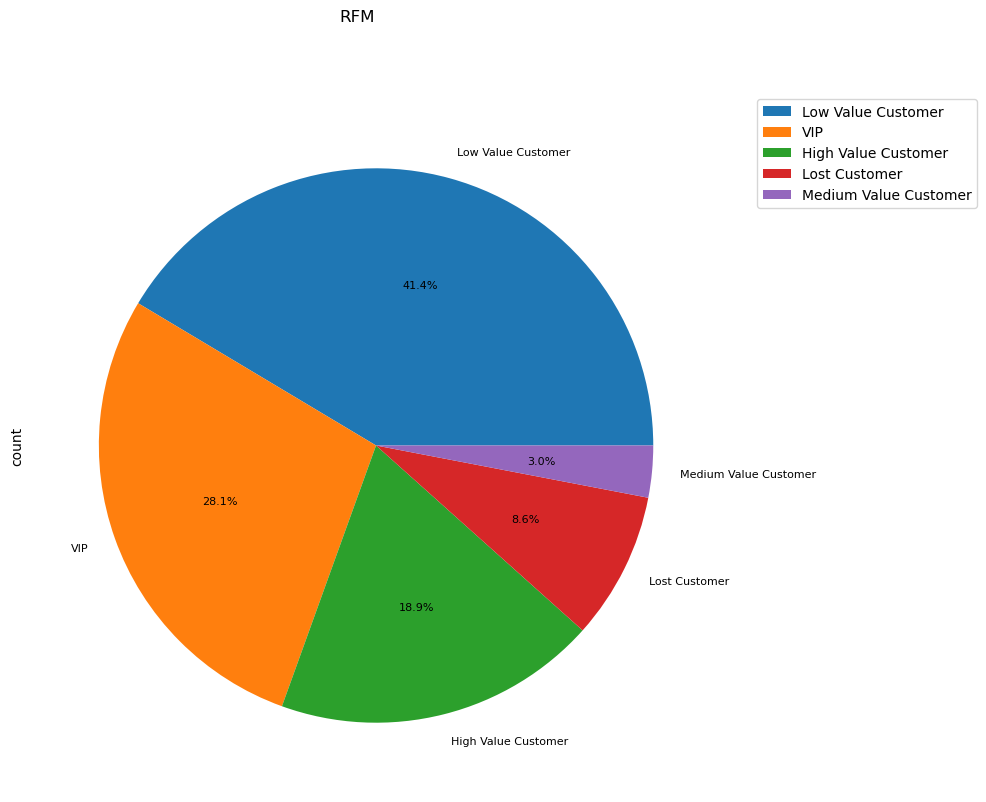

In [14]:
# 繪製RFM客戶類別分布圖
rfm['Customer_segment'].value_counts().plot(kind='pie',
                      figsize=(15, 9),
                      autopct='%.1f%%',
                      title='RFM',
                      textprops={'fontsize': 8},
                      subplots=True)
plt.legend(loc=2, bbox_to_anchor=(1.05, 1.0), borderaxespad=0)